### Finished project

In [117]:
from typing import List

from skimage.io import imread, imshow
from skimage.transform import resize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import json
from PIL import (
    Image,
    ImageDraw
)
import cv2

import skimage.io
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

# !pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import albumentations as A
import torch.nn as nn
import random
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

random.seed(11)

In [351]:
dataset_path = '../DeepFashion2Dataset'
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')
test_dir = os.path.join(dataset_path, 'test/test')

In [3]:
# Data Processing:
#### we can load the data from 

# Load Images from Local storage

In [6]:
class FormImagesDataFrame:
    def __init__(self, train_path: str):
        self.train_path = train_path

        images_path = os.path.join(self.train_path, 'image')
        self.images_df = self._load_images_df(images_path)

    def get_imges_df(self):
        return self.images_df

    def _load_images_df(self, images_dir):
        images_list = [os.path.join(images_dir, img_path) for img_path in os.listdir(images_dir)]
        image_df = pd.DataFrame(images_list, columns=['img_path'])
        image_id = image_df['img_path'].apply(
            lambda x: os.path.splitext(os.path.basename(x))[0]
        ).astype(int)

        return image_df.set_index(image_id)

    def __repr__(self):
        return "Images df: ", type(self.images_df)


class FormAnnosDataFrame:
    def __init__(self, train_path: str):
        self.train_path = train_path

        annotations_path = os.path.join(self.train_path, 'annos')
        self.annotations_df = self._load_annotations_df(annotations_path)

    def get_annos_df(self):
        return self.annotations_df

    def _read_annos(self, annos_path: str):
        annos_id = os.path.splitext(os.path.basename(annos_path))[0]

        with open(annos_path, 'r') as f:
            metadata = json.load(f)
        annos_items = [metadata[k] for k in metadata.keys() if 'item' in k]
        for item in annos_items:
            item.update({'id': int(annos_id)})
        return annos_items

    def _load_annotations_df(self, annos_dir: str):
        # list of lists with one dictionary inside
        annotations = [self._read_annos(os.path.join(annos_dir, annos_path))[0] for annos_path in os.listdir(annos_dir)]
        return pd.DataFrame(annotations).set_index('id')

    def __repr__(self):
        return "Annos: ", type(self.annotations_df)

#### Number of items for training
191961 images
191961 annotations

In [8]:
image_formation = FormImagesDataFrame(train_dir)
annos_formation = FormAnnosDataFrame(train_dir)

In [12]:
class FormCommonDataFrame:
    def __init__(self, image_formation, annos_formation):
        self.df = (annos_formation.get_annos_df()).join((image_formation.get_imges_df()), how='left')
        self._make_dataset_df()
        
    def _make_dataset_df(self):
        self.df['scale_categorical'] = self.df['scale'].map(
            {1: 'small_scale', 2: 'modest_scale', 3: 'large_scale'}
        )
        self.df['zoom_in_categorical'] = self.df['zoom_in'].map(
            {1: 'no_zoom_in', 2: 'medium_zoom_in', 3: 'large_zoom_in'}
        )
        self.df['viewpoint_categorical'] = self.df['viewpoint'].map(
            {1: 'no_wear', 2: 'frontal_viewpoint', 3: 'side_or_back_viewpoint'}
        )
        self.df['occlusion_categorical'] = self.df['occlusion'].map(
            {1: 'slight_occlusion', 2: 'medium_occlusion', 3: 'heavy_occlusion'}
        )
        
    def get_df(self):
        return self.df

In [13]:
df = FormCommonDataFrame(image_formation, annos_formation).get_df()
df.head()

segmentation  scale  viewpoint  \
id                                                                            
116936  [[404, 598, 237, 610, 125, 527, 108, 615, 91, ...      2          2   
74592   [[333, 59, 300, 80, 245, 86, 194, 80, 174, 54,...      3          1   
13856   [[352, 82, 365, 112, 398, 113, 439, 101, 462, ...      2          2   
127292  [[316, 180, 309, 194, 316, 216, 291, 183, 251,...      1          3   
120557  [[460, 416, 361, 447, 228, 428, 227, 561, 275,...      2          2   

        zoom_in                                          landmarks  style  \
id                                                                          
116936        1  [125, 527, 2, 237, 610, 2, 404, 598, 2, 108, 6...      0   
74592         1  [251, 68, 1, 174, 54, 2, 194, 80, 2, 245, 86, ...      0   
13856         1  [399, 87, 1, 352, 82, 1, 365, 112, 2, 398, 113...      2   
127292        1  [298, 172, 1, 251, 163, 2, 291, 183, 2, 316, 2...      0   
120557        3  [228, 428, 2, 361, 447, 2, 460, 416, 2, 227, 5...      0   

                bounding_box  category_id  occlusion     category_name  \
id                                                                       
116936   [86, 510, 410, 835]            7          1            shorts   
74592     [50, 41, 443, 380]            1          1  short sleeve top   
13856    [251, 80, 612, 610]           12          2        vest dress   
127292  [195, 153, 434, 400]            2          1   long sleeve top   
120557  [209, 414, 485, 681]            8          1          trousers   

                                             img_path scale_categorical  \
id                                                                        
116936  ../DeepFashion2Dataset/train/image/116936.jpg      modest_scale   
74592   ../DeepFashion2Dataset/train/image/074592.jpg       large_scale   
13856   ../DeepFashion2Dataset/train/image/013856.jpg      modest_scale   
127292  ../DeepFashion2Dataset/train/image/127292.jpg       small_scale   
120557  ../DeepFashion2Dataset/train/image/120557.jpg      modest_scale   

       zoom_in_categorical   viewpoint_categorical occlusion_categorical  
id                                                                        
116936          no_zoom_in       frontal_viewpoint      slight_occlusion  
74592           no_zoom_in                 no_wear      slight_occlusion  
13856           no_zoom_in       frontal_viewpoint      medium_occlusion  
127292          no_zoom_in  side_or_back_viewpoint      slight_occlusion  
120557       large_zoom_in       frontal_viewpoint      slight_occlusion

In [14]:
df.to_pickle('./pkl_df_of_annos_and_images.pkl')

# Load the pickle of data frame combined annotations and images

In [15]:
df = pd.read_pickle("./pkl_df_of_annos_and_images.pkl")

In [16]:
df.head()

segmentation  scale  viewpoint  \
id                                                                            
116936  [[404, 598, 237, 610, 125, 527, 108, 615, 91, ...      2          2   
74592   [[333, 59, 300, 80, 245, 86, 194, 80, 174, 54,...      3          1   
13856   [[352, 82, 365, 112, 398, 113, 439, 101, 462, ...      2          2   
127292  [[316, 180, 309, 194, 316, 216, 291, 183, 251,...      1          3   
120557  [[460, 416, 361, 447, 228, 428, 227, 561, 275,...      2          2   

        zoom_in                                          landmarks  style  \
id                                                                          
116936        1  [125, 527, 2, 237, 610, 2, 404, 598, 2, 108, 6...      0   
74592         1  [251, 68, 1, 174, 54, 2, 194, 80, 2, 245, 86, ...      0   
13856         1  [399, 87, 1, 352, 82, 1, 365, 112, 2, 398, 113...      2   
127292        1  [298, 172, 1, 251, 163, 2, 291, 183, 2, 316, 2...      0   
120557        3  [228, 428, 2, 361, 447, 2, 460, 416, 2, 227, 5...      0   

                bounding_box  category_id  occlusion     category_name  \
id                                                                       
116936   [86, 510, 410, 835]            7          1            shorts   
74592     [50, 41, 443, 380]            1          1  short sleeve top   
13856    [251, 80, 612, 610]           12          2        vest dress   
127292  [195, 153, 434, 400]            2          1   long sleeve top   
120557  [209, 414, 485, 681]            8          1          trousers   

                                             img_path scale_categorical  \
id                                                                        
116936  ../DeepFashion2Dataset/train/image/116936.jpg      modest_scale   
74592   ../DeepFashion2Dataset/train/image/074592.jpg       large_scale   
13856   ../DeepFashion2Dataset/train/image/013856.jpg      modest_scale   
127292  ../DeepFashion2Dataset/train/image/127292.jpg       small_scale   
120557  ../DeepFashion2Dataset/train/image/120557.jpg      modest_scale   

       zoom_in_categorical   viewpoint_categorical occlusion_categorical  
id                                                                        
116936          no_zoom_in       frontal_viewpoint      slight_occlusion  
74592           no_zoom_in                 no_wear      slight_occlusion  
13856           no_zoom_in       frontal_viewpoint      medium_occlusion  
127292          no_zoom_in  side_or_back_viewpoint      slight_occlusion  
120557       large_zoom_in       frontal_viewpoint      slight_occlusion

### Find the size of images

In [17]:
all_images = df['img_path'].values

img_width, img_height = [], []
for img in all_images:
    image = Image.open(img).size
    img_width.append(image[0])
    img_height.append(image[1])

In [18]:
df['width'] = img_width
df['height'] = img_height

In [20]:
df[['width', 'height']].describe()

width         height
count  191961.000000  191961.000000
mean      604.279302     759.136851
std       152.184766     213.964123
min        68.000000      71.000000
25%       468.000000     624.000000
50%       640.000000     702.000000
75%       750.000000     940.000000
max      1320.000000    1835.000000

#### Conclusion:
We can see that the data really differs a lot. And all the image sizes are very different. We would like to resize the dataset, but before that we would also like to augment the data a bit.

# Get validation Data Frame

In [137]:
val_image_formation = FormImagesDataFrame(validation_dir)
val_annos_formation = FormAnnosDataFrame(validation_dir)
val_df = FormCommonDataFrame(val_image_formation, val_annos_formation).get_df()
val_df.head()

segmentation  scale  viewpoint  \
id                                                                           
13856  [[117.90363482670946, 361.87320371935715, 107....      3          2   
25437  [[216.1803886654836, 106.65176656170267, 232.8...      2          2   
15081  [[315.8539395245276, 395.7920461699007, 316.46...      1          2   
10779  [[165.25714285714287, 26.057142857142857, 167....      3          1   
12744  [[286.94505494505495, 679.3846153846154, 393.4...      2          2   

       zoom_in                                          landmarks  style  \
id                                                                         
13856        1  [0, 0, 0, 0, 0, 0, 191, 359, 2, 281, 337, 2, 3...      2   
25437        1  [216, 109, 1, 354, 110, 1, 438, 107, 1, 211, 3...      4   
15081        2  [316, 396, 1, 402, 397, 1, 481, 379, 1, 335, 4...      0   
10779        3  [0, 0, 0, 0, 0, 0, 218, 21, 2, 244, 71, 2, 241...      1   
12744        3  [289, 683, 1, 396, 675, 1, 497, 676, 1, 273, 8...      0   

               bounding_box  category_id  occlusion       category_name  \
id                                                                        
13856  [107, 239, 531, 955]           10          1  short sleeve dress   
25437  [183, 100, 478, 489]            7          2              shorts   
15081  [305, 378, 515, 642]            8          2            trousers   
10779      [1, 2, 466, 623]            2          1     long sleeve top   
12744  [265, 670, 555, 959]            8          2            trousers   

                                                img_path scale_categorical  \
id                                                                           
13856  ../DeepFashion2Dataset/validation/image/013856...       large_scale   
25437  ../DeepFashion2Dataset/validation/image/025437...      modest_scale   
15081  ../DeepFashion2Dataset/validation/image/015081...       small_scale   
10779  ../DeepFashion2Dataset/validation/image/010779...       large_scale   
12744  ../DeepFashion2Dataset/validation/image/012744...      modest_scale   

      zoom_in_categorical viewpoint_categorical occlusion_categorical  
id                                                                     
13856          no_zoom_in     frontal_viewpoint      slight_occlusion  
25437          no_zoom_in     frontal_viewpoint      medium_occlusion  
15081      medium_zoom_in     frontal_viewpoint      medium_occlusion  
10779       large_zoom_in               no_wear      slight_occlusion  
12744       large_zoom_in     frontal_viewpoint      medium_occlusion

# Data Investigation

In [21]:
def display_instances(df: pd.DataFrame, col_name: str, n_cols=7):
    n = len(df)
    n_rows = int(np.ceil(n/n_cols))
    # Estimate figsize
    figsize = (3*n_cols, 3.75*n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    for i in range(n):
        row = df.iloc[i]
        
        if n_rows == 1:
            ax = axes[i]
        else:
            i_idx, j_idx = np.unravel_index(i, (n_rows, n_cols))
            ax = axes[i_idx][j_idx]
        
            # show image
            ax.imshow(skimage.io.imread(row['img_path']), aspect='auto')
            ax.set_title(row[col_name], fontsize=14)
            ax.axis('off')

        fig.tight_layout()

### By cathegory

In [22]:
def group_by_cathegory(df: pd.DataFrame, col, n_samples=7):
    return df.groupby(col).apply(lambda x: x.sample(n_samples)).reset_index(level=0, drop=True).reset_index()

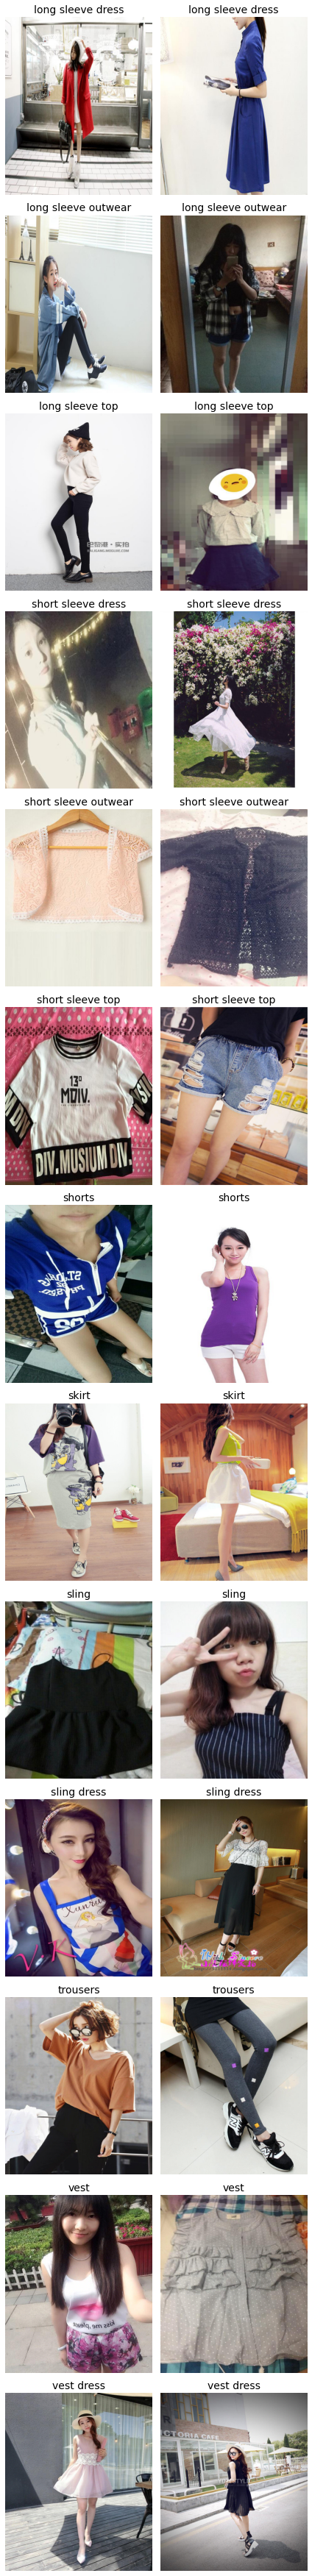

In [23]:
column = 'category_name'
display_instances(group_by_cathegory(df, column, 2), column, n_cols=2)

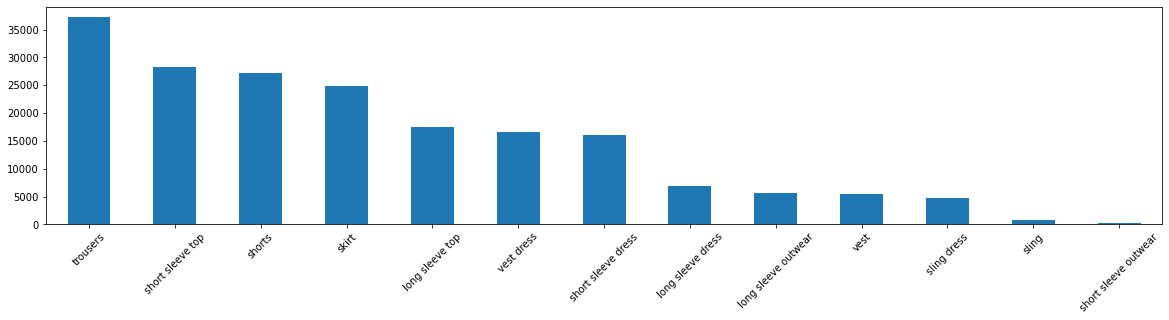

In [24]:
df[column].value_counts().plot.bar(figsize=(20, 4), rot=45);

### Apply masks

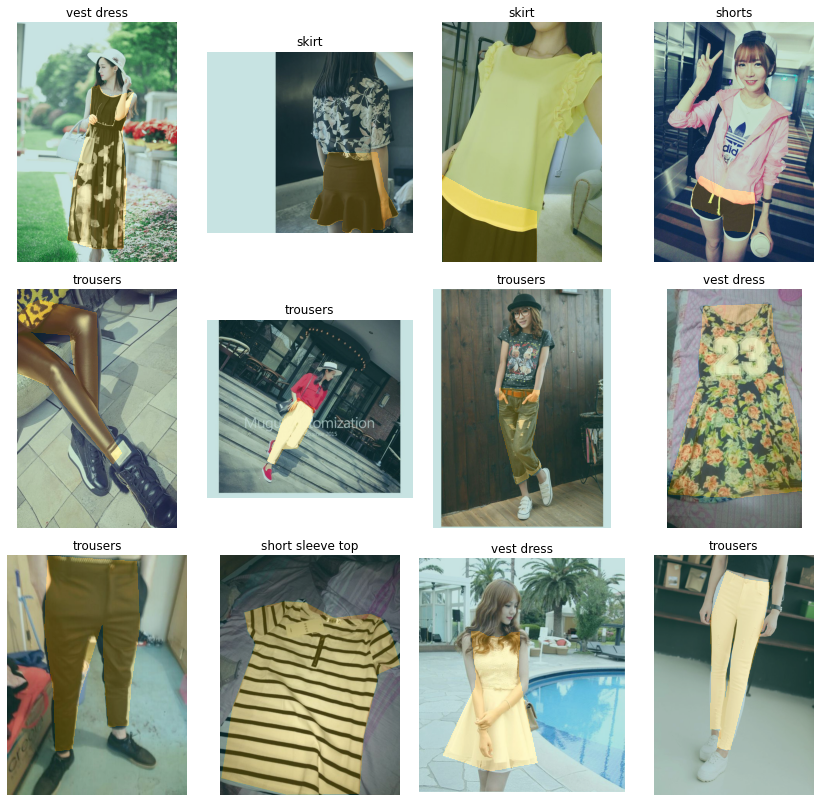

In [25]:
def get_mask(height: int,
             width: int,
             polygons: List,
             category_id: int) -> np.ndarray:
    default_value = 0
    # See https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
    mask = Image.new(mode='L', size=(width, height), color=default_value)
    # Fill each of the input polygons
    for polygon in polygons:
        ImageDraw.Draw(mask).polygon(polygon,
                                     outline=category_id,
                                     fill=category_id)
    return np.array(mask)

def display_masks(image: np.ndarray, masks: List, ax=None):
    # Display image
    if ax is not None:
        axis = ax
    else:
        plt.figure(figsize=(8, 15))
        axis = plt
    axis.imshow(image)
    
    # Display all masks
    for mask in masks:
        axis.imshow(mask, alpha=0.25, vmin=-1.0, vmax=1.0)

        
def instance_to_mask(row: pd.Series) -> np.ndarray:
    image = imread(row['img_path'])
    image_height, image_width = image.shape[:2]
    return get_mask(image_height,
                    image_width,
                    polygons=row['segmentation'],
                    category_id=int(row['category_id']))


def display_instance_mask(row: pd.Series, ax) -> None:
    masks = [instance_to_mask(row)]
    image = imread(row['img_path'])
    display_masks(image, masks, ax=ax)
    ax.set_title(row["category_name"])
    ax.axis('off')
    
def display_img_masks(df: pd.DataFrame, col_name: str, display_fn, n_cols=7):
    n = len(df)
    n_rows = int(np.ceil(n/n_cols))
    # Estimate figsize
    figsize = (3*n_cols, 3.75*n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    for i in range(n):
        row = df.iloc[i]
        
        if n_rows == 1:
            ax = axes
        else:
            i_idx, j_idx = np.unravel_index(i, (n_rows, n_cols))
            ax = axes[i_idx][j_idx]
        
        # show mask
        display_fn(row, ax)

        fig.tight_layout()
    
mask_sample = df.sample(12)
display_img_masks(mask_sample, 'Masks', display_fn=display_instance_mask, n_cols=4)

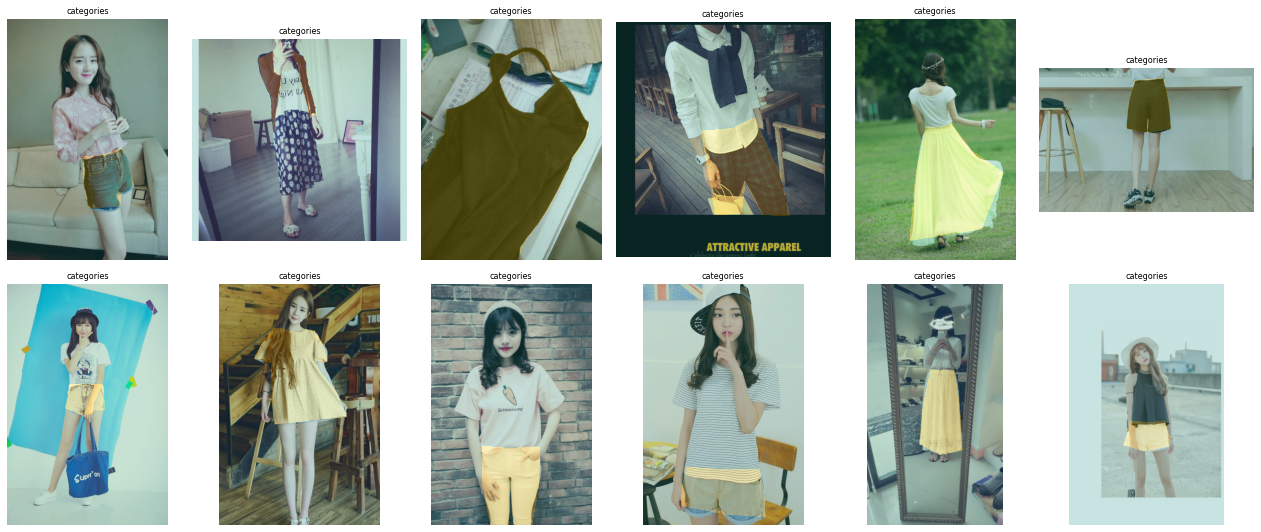

In [26]:
def display_all_instance_masks(row: pd.Series, ax) -> None:
    items = df[df.index == row.name]
    masks = items.apply(instance_to_mask, axis=1).values.tolist()
    image = imread(row['img_path'])
    display_masks(image, masks, ax=ax)
    # Displau call categories
    categories = items["category_name"].values.tolist()
    ax.set_title('categories', fontsize=8)
    ax.axis('off')

samples = df.sample(12)
display_img_masks(samples, 'Images with masks', display_all_instance_masks, 6)

### Images Investigation for the Preprocessing

In [27]:
df[df['width'] > 1000]['segmentation']

id
543       [[1056, 176, 816, 109, 642, 4, 472, 224, 293, ...
6706      [[16.0, 132.0, 44.05, 103.22, 72.12, 95.35, 16...
155830    [[1123, 164, 886, 152, 778, 65, 589, 193, 420,...
544       [[1125, 218, 921, 122, 820, 2, 604, 145, 353, ...
75036     [[345, 3, 200, 172, 4, 337, 370, 610, 686, 694...
168100    [[407.14, 1.39, 315.52, 89.21, 235.64, 149.19,...
140451    [[840.8, 592.2, 844.0, 608.0, 850.0, 621.0, 85...
71182     [[836, 472, 761, 568, 670, 609, 712, 712, 786,...
129893    [[771.92, 176.91, 764.84, 167.77, 758.36, 152....
Name: segmentation, dtype: object

In [28]:
df[df['width'] > 1000].iloc[[3]]['segmentation'].values

array([list([[1125, 218, 921, 122, 820, 2, 604, 145, 353, 275, 290, 471, 339, 506, 406, 350, 798, 225, 388, 364, 307, 572, 364, 610, 478, 461, 816, 406, 1125, 218], [921, 122, 820, 2, 604, 145, 353, 275, 290, 471, 339, 506, 406, 350, 798, 225, 921, 122], [1125, 218, 921, 122, 798, 225, 388, 364, 307, 572, 364, 610, 478, 461, 816, 406, 1125, 218]])],
      dtype=object)

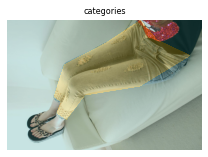

In [29]:
display_img_masks(df[df.index == 544], 'Image with a large width scale', display_all_instance_masks, 1)

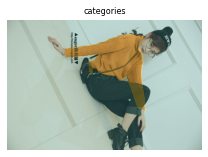

In [30]:
display_img_masks(df[df.index == 129893], 'Image with a large width scale', display_all_instance_masks, 1)

In [31]:
df[df['height'] > 1000]['segmentation']

id
25437     [[405, 332, 404, 347, 387, 356, 364, 352, 345,...
146781    [[350, 546, 304, 543, 253, 528, 216, 606, 188,...
46119     [[438, 505, 367, 509, 285, 509, 292, 616, 308,...
65679     [[493, 930, 363, 959, 258, 899, 236, 1014, 247...
1168      [[143.88, 310.42, 165.58, 310.07, 170.58, 333....
                                ...                        
136228    [[282, 481, 329, 482, 377, 482, 397, 636, 418,...
154814    [[413, 238, 396, 257, 376, 269, 343, 272, 314,...
149725    [[449, 231, 424, 239, 398, 248, 384, 242, 384,...
1239      [[418, 821, 279, 790, 174, 736, 143, 829, 118,...
17617     [[642, 262, 325, 297, 26, 306, 190, 583, 398, ...
Name: segmentation, Length: 22375, dtype: object

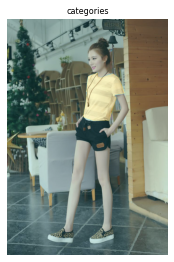

In [32]:
display_img_masks(df[df.index == 149725], 'Image with a large height scale', display_all_instance_masks, 1)

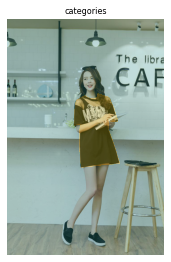

In [33]:
display_img_masks(df[df.index == 25437], 'Image with a large height scale', display_all_instance_masks, 1)

In [ ]:
# def instance_to_mask_(row: pd.Series) -> np.ndarray:
#     image = imread(row['img_path'].values[0])
#     print(image.shape)
#     image_height, image_width = image.shape[:2]
# #     default_value = 0
# #     mask = Image.new(mode='L', size=(image_width, image_height), color=default_value)
# #     for polygon in polygons:
# #         ImageDraw.Draw(mask).polygon(polygon,
# #                                      outline=category_id,
# #                                      fill=category_id)
# #     return np.array(mask)
#     return get_mask(image_height,
#                     image_width,
#                     polygons=row['segmentation'].values[0],
#                     category_id=int(row['category_id'].values[0]))

# index = 25437
# row = df[df.index == 116936]

# a = instance_to_mask_(row)
# b = a[:, :, np.newaxis]
# b.shape

In [35]:
class DataAug:
    def __init__(self):
        self.img_height, self.img_width = 128, 128
    
    def create_augmentation_pipe(self, image):
        original_height, original_width = image.shape[:2]
        return A.Compose([
                    A.PadIfNeeded(min_height=original_height, min_width=original_width, p=1),
                    A.HorizontalFlip(p=0.2),
                    A.VerticalFlip(p=0.4),              
                    A.RandomRotate90(p=0.4),
                    A.CLAHE(p=0.2),
                    A.RandomBrightnessContrast(p=0.2),    
                    A.RandomGamma(p=0.2),
                    A.augmentations.transforms.Resize(self.img_height, self.img_width, p=1),
                ])
    
    def show_img_and_mask(self, image, mask):
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        ax[0].imshow(image)
        ax[1].imshow(mask)


1it [00:00,  5.57it/s]


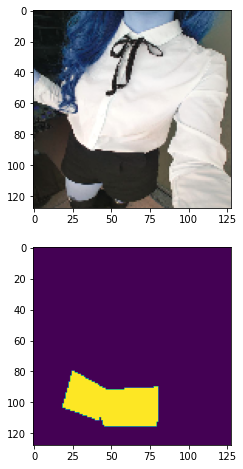

In [36]:
imagesDs = DataAug()

for index, row in tqdm(df.iterrows()):
    if index == 74592:
        break
    image = cv2.imread(row['img_path'])
    mask = instance_to_mask(row)
    
    aug = imagesDs.create_augmentation_pipe(image)
    augmented = aug(image=image, mask=mask)

    image_heavy = augmented['image']
    mask_heavy = augmented['mask']

    imagesDs.show_img_and_mask(image_heavy, mask_heavy)


# Prepare Datasets for training

In [332]:
def create_augmentation_pipe():
    img_height, img_width = 128, 128
#     original_height, original_width = image.shape[:2]
    return A.Compose([
#                 A.PadIfNeeded(min_height=original_height, min_width=original_width, p=1),
                A.HorizontalFlip(p=0.2),
                A.VerticalFlip(p=0.4),              
                A.RandomRotate90(p=0.4),
                A.CLAHE(p=0.2),
                A.RandomBrightnessContrast(p=0.2),    
                A.RandomGamma(p=0.2),
                A.augmentations.transforms.Resize(img_height, img_width, p=1),
            ])

In [333]:
def to_tensor(x, **kwargs):
    return x.transpose((2, 0, 1)).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [340]:
class Dataset(BaseDataset):
    """
    Read mages, apply augmentation and preprocessing transformations.
    Args:
        df(DataFrame of combined data): images, annotations names, classes
        augmentation (albumentations.Compose): data transfromation pipeline
        preprocessing (albumentations.Compose): data preprocessing (e.g. noralization, shape manipulation, etc.))
    """
    CLASSES = [set(df['category_id'])]
    
    def __init__(self, df, augmentation=None, preprocessing=None):
        self.df = df
        
        self.class_values = [self.CLASSES.index(cls) for cls in self.CLASSES]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def _instance_to_mask(self, row: pd.Series) -> np.ndarray:
        image = imread(row['img_path'])
        image_height, image_width = image.shape[:2]

        default_value = 0
        mask = Image.new(mode='L', size=(image_width, image_height), color=default_value)
        for polygon in row['segmentation']:
            ImageDraw.Draw(mask).polygon(polygon,
                                         outline=int(row['category_id']),
                                         fill=int(row['category_id']))
        return np.array(mask)
    
    def __getitem__(self, i):
        row = self.df.iloc[i]
        image = cv2.imread(row['img_path']) # np array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = self._instance_to_mask(row) # np array
#         mask = mask[:, :, np.newaxis]
        
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        if self.augmentation:
            # create_augmentation_pipe
            aug = self.augmentation(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']
        
        if self.preprocessing:
            # get_preprocessing
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask

    def __len__(self):
        return len(self.df)

In [341]:
ENCODER = 'vgg16'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = [set(df['category_id'])]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
# DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_unet = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [342]:
train_dataset = Dataset(df, augmentation=create_augmentation_pipe(), preprocessing=get_preprocessing(preprocessing_unet))
val_dataset = Dataset(val_df, augmentation=create_augmentation_pipe(), preprocessing=get_preprocessing(preprocessing_unet))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) #, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) #, num_workers=4)

In [343]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps=1., threshold=0.5, activation=None),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [344]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
#     device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
#     device=DEVICE,
    verbose=True,
)

In [345]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i)) 
#     train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100%|██████████| 23996/23996 [39:48:43<00:00,  5.97s/it, dice_loss - 0.07146, iou_score - 0.8718]     


NameError: name 'valid_loader' is not defined

# Create Test Dataset

In [354]:
test_df = FormImagesDataFrame(test_dir).get_imges_df()
test_df.head()

img_path
img_path                                                   
52628     ../DeepFashion2Dataset/test/test/image/052628.jpg
45354     ../DeepFashion2Dataset/test/test/image/045354.jpg
3301      ../DeepFashion2Dataset/test/test/image/003301.jpg
13112     ../DeepFashion2Dataset/test/test/image/013112.jpg
55147     ../DeepFashion2Dataset/test/test/image/055147.jpg

In [359]:
test_dataset = Dataset(test_df) #, augmentation=create_augmentation_pipe(), preprocessing=get_preprocessing(preprocessing_unet))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) #, num_workers=4)

In [393]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

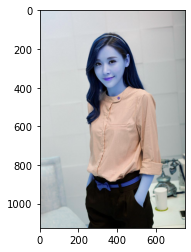

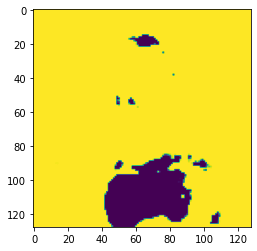

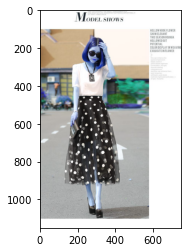

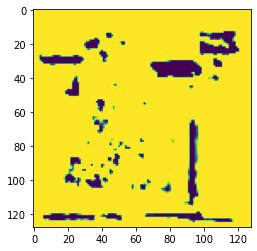

In [412]:
img_height, img_width = 128, 128
for i, row in test_df.iterrows():
    if i ==3301:
        break
    img = cv2.imread(row.values[0])
    plt.imshow(img)
    plt.show();
    aug = A.Compose([
                A.augmentations.transforms.Resize(img_height, img_width, p=1),
            ])
    aug = aug(image=img)
    img = aug['image']
    img = img[np.newaxis, :, :, :] # add batch
    # (batch_size, channels, height, width)
    img = img.transpose(0, 3, 1, 2)
    pr_mask = best_model.predict(torch.tensor(img, dtype=torch.float32))

    plt.imshow(pr_mask.squeeze())
    plt.show();

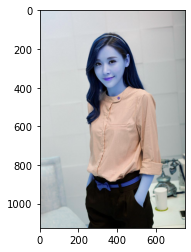

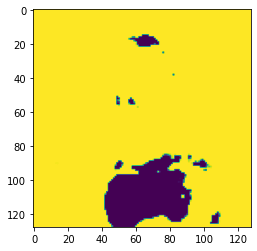

In [409]:
img = cv2.imread(row.values[1])
plt.imshow(img)
plt.show();
plt.imshow(pr_mask.squeeze())
plt.show();

In [391]:
# model.predict(test_loader)